# Stochastic Interest Rates and Swaptions

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm  #### loop 
import plotly
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.neighbors import KernelDensity
from scipy.stats import norm, gaussian_kde
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import scipy.integrate as integrate

In [2]:
def pnl_plot(dist): 
    p=np.percentile (dist,5) #95% percentail - lower bound
    kde = stats.gaussian_kde(dist)
    # plot complete kde curve as line
    pos = np.linspace(dist.min(), dist.max(), 101)
    plt.plot(pos, kde(pos))
    # plot shaded kde only 95% percentile
    shade = np.linspace(dist.min(),p,101)
    plt.fill_between(shade,kde(shade), alpha=0.5)

In [3]:
def pnl_summary(dist):
    Mean = np.mean(dist)
    std = np.std(dist)
    VaR = np.percentile(dist,5)
    CVaR = np.mean(dist[dist<VaR])
    skewness=stats.skew(dist, bias=False)
    kurt = stats.kurtosis(dist, bias=False)
    print('Mean=%0.5f, Std=%0.5f, VaR=%0.5f, CVaR=%0.5f, skewness=%0.5f, kurtosis=%0.5f' %
         (Mean,std,VaR,CVaR,skewness,kurt))


In [4]:
# time setting
T = 10
ndt = 365*T #length of time interval =length of t
t = np.linspace (0,T,ndt)
dt = t[1]-t[0]
r0 = 0.02
theta0 = 0.03
alpha = 3 # k
sigma = 0.01 
beta = 1
phi = 0.05
eta = 0.005
nsims=1000

In [5]:
def simtheta (t,beta,phi,eta,nsims):
    ndt = len(t)
    dt = t[1]-t[0]
    sqrt_dt = np.sqrt(dt)
    
    theta_t=np.zeros((nsims,ndt))
    theta_t[:,0] = theta0
    
    for i in range(len(t)-1):
        theta_t[:,i+1]=theta_t[:,i]+beta*(phi-theta_t[:,i])*dt+eta*sqrt_dt*np.random.randn(nsims)
    
    return theta_t


def simr (t,alpha,theta,sigma,nsims):
    ndt = len(t)
    dt = t[1]-t[0]
    sqrt_dt = np.sqrt(dt)
    
    rt=np.zeros((nsims,ndt))
    rt[:,0] = r0
    
    for i in range(len(t)-1):
        rt[:,i+1]=rt[:,i]+alpha*(theta[:,i]-rt[:,i])*dt+sigma*sqrt_dt*np.random.randn(nsims)
    
    return rt

def BondYp (t,rt,nsims):
    
    delta_t = np.zeros((nsims,ndt))
    for i in range(1,len(t)):
        delta_t[:,i]=rt[:,i-1]*dt
    # short rate integral
    integral_r = np.zeros((nsims,ndt))
    integral_r = np.cumsum(delta_t,axis=1)
    
    #bond price and bond yield
    bondprice = np.mean(np.exp(-integral_r),axis=0)
    bondyield = np.zeros(len(t))
    bondyield[0] = np.mean(rt[:,0])
    bondyield[1:]=-np.log(bondprice[1:])/t[1:]
    
    return bondyield,bondprice

In [6]:
#analyitical
def B(alpha,t):
    B_t = (1-np.exp(-alpha*t))/alpha
    return B_t

def C(alpha,beta,t,B_t):
    C_t = (alpha/(alpha-beta))*((1-np.exp(-beta*t))/beta - B_t)
    return C_t

def A(alpha,beta,sigma,phi,eta,t,B_t,C_t):
    O1 = t/beta**2-(2*(B_t+C_t))/beta**2+(1-np.exp(-2*alpha*t))/(2*alpha*(alpha-beta)**2)
    
    O21 = -(2*alpha/(beta*(alpha-beta)**2))*(1-np.exp(-(alpha+beta)*t))/(alpha+beta)
    O22= ((alpha/(beta*(alpha-beta)))**2)*((1-np.exp(-2*beta*t))/(2*beta))
    O2=O21+O22
    
    A_t = (B_t-t)*(phi-sigma**2/(2*alpha**2))+C_t*phi-(sigma*B_t)**2/(4*alpha)+0.5*(eta**2)*(O1+O2)
    return A_t

Text(0.5, 0, 'Time to maturity')

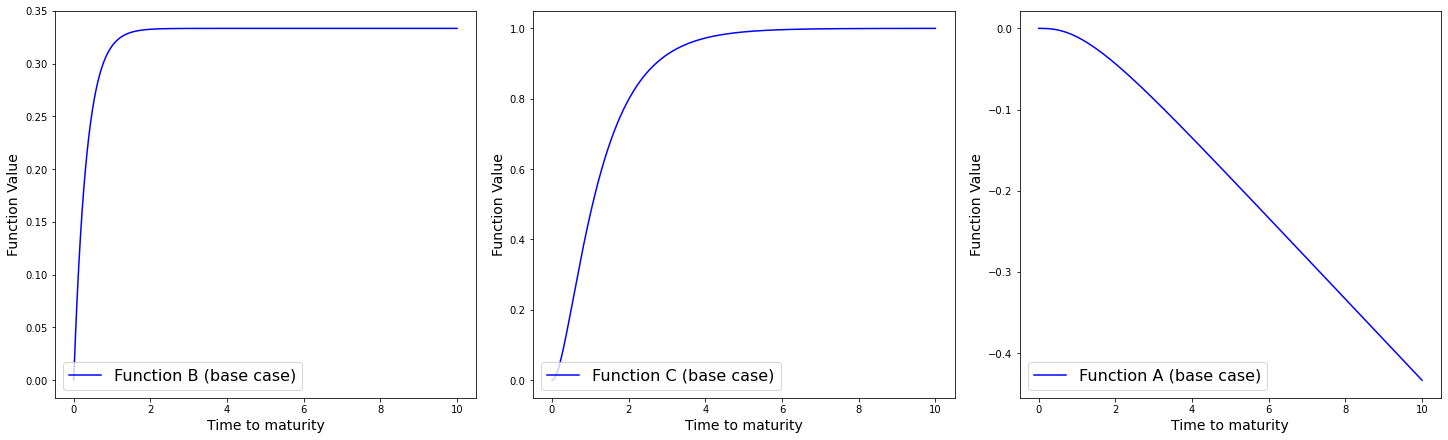

In [7]:
fig2, f2_axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True,figsize=(20,6))
#f2_axes[0].plot(t,B(4,t),color='g',label = "Function B (alpha = 4)")
f2_axes[0].plot(t,B(alpha,t),color='b',label = "Function B (base case)")
#f2_axes[0].plot(t,B(2,t),color='k',label = "Function B (alpha = 2)")
f2_axes[0].legend(loc=3,prop={'size': 16})
f2_axes[0].set_ylabel('Function Value', fontsize=14)
f2_axes[0].set_xlabel('Time to maturity', fontsize=14)

#f2_axes[1].plot(x,gamma(K, tau, x, r, 0.5*sigma),color='g',label='Volatility = 10%')
f2_axes[1].plot(t,C(alpha,beta,t,B(alpha,t)),color='b',label='Function C (base case)')
#f2_axes[1].plot(x,gamma(K, tau, x, r, 1.5*sigma),color='k',label='Volatility = 30%')
f2_axes[1].legend(loc=3,prop={'size': 16})
f2_axes[1].set_ylabel('Function Value', fontsize=14)
f2_axes[1].set_xlabel('Time to maturity', fontsize=14)

#f2_axes[2].plot(x,gamma(K, tau, x, r, sigma),color='g',label='Risk-free rate = 0.02')
f2_axes[2].plot(t,A(alpha,beta,sigma,phi,eta,t,B(alpha,t),C(alpha,beta,t,B(alpha,t))),color='b',label='Function A (base case)')
#f2_axes[2].plot(x,gamma(K, tau, x, 10*r, sigma),color='k',label='Risk-free rate = 0.2')
f2_axes[2].legend(loc=3,prop={'size': 16})
f2_axes[2].set_ylabel('Function Value', fontsize=14)
f2_axes[2].set_xlabel('Time to maturity', fontsize=14)



In [8]:
def bond_sim (alpha,beta,sigma,phi,eta,t,nsims):
    theta=simtheta(t,beta,phi,eta,nsims)
    rt=simr(t,alpha,theta,sigma,nsims)
    bondyield,bondprice = BondYp(t,rt,1000)
    
    return bondyield #,bondprice

In [9]:
def bond_analytical (alpha,beta,sigma,phi,eta,t):
    B_t=B(alpha,t)
    C_t=C(alpha,beta,t,B_t)
    A_t=A(alpha,beta,sigma,phi,eta,t,B_t,C_t)
    return (-A_t+B_t*r0+C_t*theta0)/t

#base case
r0 = 0.02
theta0 = 0.03
alpha = 3 # k
sigma = 0.01 
beta = 1
phi = 0.05
eta = 0.005
nsims=1000

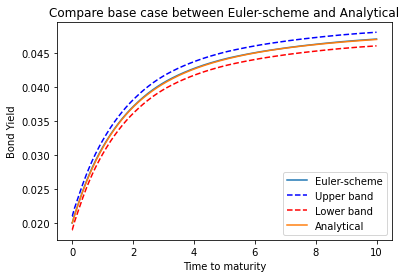

In [10]:
# compare base case between Euler-scheme and Analytical
b0=bond_sim(alpha,beta,sigma,phi,eta,t,nsims)
uband = b0+0.001
dband = b0-0.001

plt.plot(t,b0,label = "Euler-scheme")
plt.plot(t,uband,'--b',label = "Upper band")
plt.plot(t,dband,'--r',label = "Lower band")
plt.plot(t,bond_analytical (alpha,beta,sigma,phi,eta,t),label = "Analytical")
plt.title("Compare base case between Euler-scheme and Analytical")
plt.xlabel("Time to maturity")
plt.ylabel("Bond Yield")
plt.legend()
plt.show()

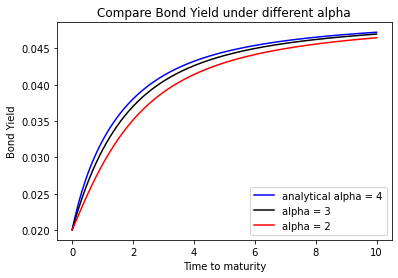

In [11]:
#plt.plot(t,bond_sim(alpha+1,beta,sigma,phi,eta,t,nsims),'-b',label = "alpha = 4")
plt.plot(t,bond_analytical(alpha+1,beta,sigma,phi,eta,t),'-b',label = "analytical alpha = 4")
plt.plot(t,bond_analytical(alpha,beta,sigma,phi,eta,t),color='black',label = "alpha = 3") #base case
#plt.plot(t,bond_analytical(alpha,beta,sigma,phi,eta,t),'-b',label = "analytical alpha = 3")
plt.plot(t,bond_analytical(alpha-1,beta,sigma,phi,eta,t),'-r',label = "alpha = 2")
#plt.plot(t,bond_analytical(alpha-1,beta,sigma,phi,eta,t),'-b',label = "analytical alpha = 2")
#plt.plot(t,bond_analytical (alpha,beta,sigma,phi,eta,t),label = "Analytical")
plt.title("Compare Bond Yield under different alpha")
plt.xlabel("Time to maturity")
plt.ylabel("Bond Yield")
plt.legend()
plt.show()

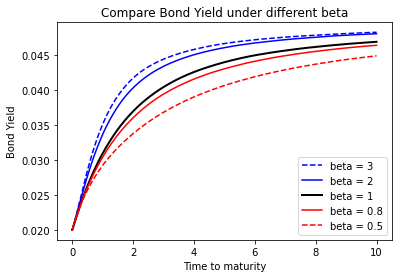

In [12]:
plt.plot(t,bond_sim(alpha,beta+2,sigma,phi,eta,t,nsims),'--b',label = "beta = 3")
#plt.plot(t,bond_analytical(alpha,beta+1,sigma,phi,eta,t),'--r',label = "analytical beta = 2")
plt.plot(t,bond_sim(alpha,beta+1,sigma,phi,eta,t,nsims),'-b',label = "beta = 2")
plt.plot(t,bond_sim(alpha,beta,sigma,phi,eta,t,nsims),linewidth=2,color='black',label = "beta = 1") #base case
plt.plot(t,bond_sim(alpha,beta-0.2,sigma,phi,eta,t,nsims),'-r',label = "beta = 0.8")
plt.plot(t,bond_sim(alpha,beta-0.5,sigma,phi,eta,t,nsims),'--r',label = "beta = 0.5")
#plt.plot(t,bond_analytical (alpha,beta,sigma,phi,eta,t),label = "Analytical")
plt.title("Compare Bond Yield under different beta")
plt.xlabel("Time to maturity")
plt.ylabel("Bond Yield")
plt.legend()
plt.show()

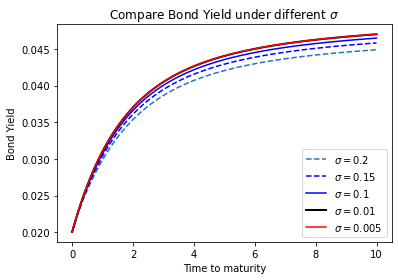

In [13]:
plt.plot(t,bond_analytical(alpha,beta,0.2,phi,eta,t),'--',label = "$\sigma = 0.2$")
plt.plot(t,bond_analytical(alpha,beta,0.15,phi,eta,t),'--b',label = "$\sigma = 0.15$")
plt.plot(t,bond_analytical(alpha,beta,0.1,phi,eta,t),'-b',label = "$\sigma = 0.1$")
plt.plot(t,bond_analytical(alpha,beta,sigma,phi,eta,t),linewidth=2,color='black',label = "$\sigma = 0.01$") #base case
plt.plot(t,bond_analytical(alpha,beta,0.005,phi,eta,t),'-r',label = "$\sigma = 0.005$")
#plt.plot(t,bond_sim(alpha,beta-0.5,sigma,phi,eta,t,nsims),'--r',label = "beta = 0.5")
#plt.plot(t,bond_analytical (alpha,beta,sigma,phi,eta,t),label = "Analytical")
plt.title("Compare Bond Yield under different $\sigma$")
plt.xlabel("Time to maturity")
plt.ylabel("Bond Yield")
plt.legend()
plt.show()

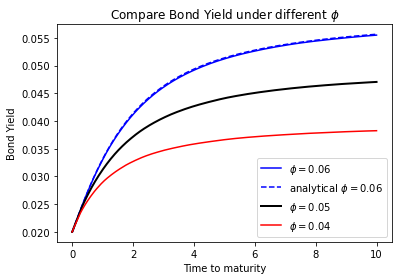

In [14]:
#plt.plot(t,bond_sim(alpha,beta,sigma,phi,eta,t,nsims),'--',label = "$\sigma = 0.2$")
#plt.plot(t,bond_sim(alpha,beta,sigma,phi,eta,t,nsims),'--b',label = "$\sigma = 0.15$")
plt.plot(t,bond_sim(alpha,beta,sigma,0.06,eta,t,nsims),'-b',label = "$\phi = 0.06$")
plt.plot(t,bond_analytical(alpha,beta,sigma,0.06,eta,t),'--b',label = "analytical $\phi = 0.06$")
plt.plot(t,bond_sim(alpha,beta,sigma,phi,eta,t,nsims),linewidth=2,color='black',label = "$\phi = 0.05$") #base case
plt.plot(t,bond_sim(alpha,beta,sigma,0.04,eta,t,nsims),'-r',label = "$\phi = 0.04$")
#plt.plot(t,bond_sim(alpha,beta-0.5,sigma,phi,eta,t,nsims),'--r',label = "beta = 0.5")
#plt.plot(t,bond_analytical (alpha,beta,sigma,phi,eta,t),label = "Analytical")
plt.title("Compare Bond Yield under different $\phi$")
plt.xlabel("Time to maturity")
plt.ylabel("Bond Yield")
plt.legend()
plt.show()

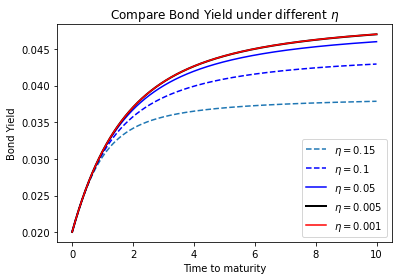

In [15]:
plt.plot(t,bond_analytical(alpha,beta,sigma,phi,0.15,t),'--',label = "$\eta = 0.15$")
plt.plot(t,bond_analytical(alpha,beta,sigma,phi,0.1,t),'--b',label = "$\eta = 0.1$")
plt.plot(t,bond_analytical(alpha,beta,sigma,phi,0.05,t),'-b',label = "$\eta = 0.05$")
plt.plot(t,bond_analytical(alpha,beta,sigma,phi,eta,t),linewidth=2,color='black',label = "$\eta = 0.005$") #base case
plt.plot(t,bond_analytical(alpha,beta,sigma,phi,0.001,t),'-r',label = "$\eta = 0.001$")
#plt.plot(t,bond_sim(alpha,beta-0.5,sigma,phi,eta,t,nsims),'--r',label = "beta = 0.5")
#plt.plot(t,bond_analytical (alpha,beta,sigma,phi,eta,t),label = "Analytical")
plt.title("Compare Bond Yield under different $\eta$")
plt.xlabel("Time to maturity")
plt.ylabel("Bond Yield")
plt.legend()
plt.show()

Text(0.5, 0, 'Time to maturity - low bond yield')

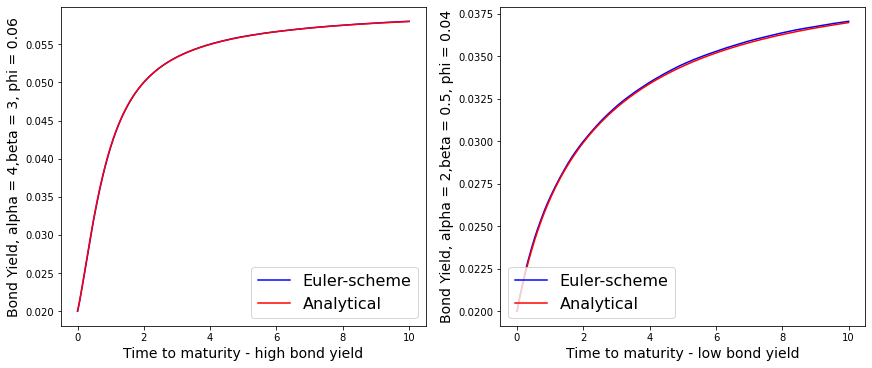

In [16]:
fig2, f2_axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True,figsize=(12,5))
f2_axes[0].plot(t,bond_sim(4,3,sigma,0.06,eta,t,nsims),'-b',label = "Euler-scheme")
f2_axes[0].plot(t,bond_analytical(4,3,sigma,0.06,eta,t),'-r',label = "Analytical")
#f2_axes[0].plot(t,B(2,t),color='k',label = "Function B (alpha = 2)")
f2_axes[0].legend(loc=4,prop={'size': 16})
#f2_axes[0].title('Compare Euler-scheme and Analytical - high bond yield')
f2_axes[0].set_ylabel("Bond Yield, alpha = 4,beta = 3, phi = 0.06", fontsize=14)
f2_axes[0].set_xlabel('Time to maturity - high bond yield', fontsize=14)

f2_axes[1].plot(t,bond_sim(2,0.5,sigma,0.04,eta,t,nsims),'-b',label = "Euler-scheme")
f2_axes[1].plot(t,bond_analytical(2,0.5,sigma,0.04,eta,t),'-r',label = "Analytical")
#f2_axes[1].plot(x,gamma(K, tau, x, r, 1.5*sigma),color='k',label='Volatility = 30%')
f2_axes[1].legend(loc=3,prop={'size': 16})
#f2_axes[1].title('Compare Euler-scheme and Analytical - low bond yield')
f2_axes[1].set_ylabel('Bond Yield, alpha = 2,beta = 0.5, phi = 0.04', fontsize=14)
f2_axes[1].set_xlabel('Time to maturity - low bond yield', fontsize=14)



Text(0.5, 0, 'Time to maturity - high vol')

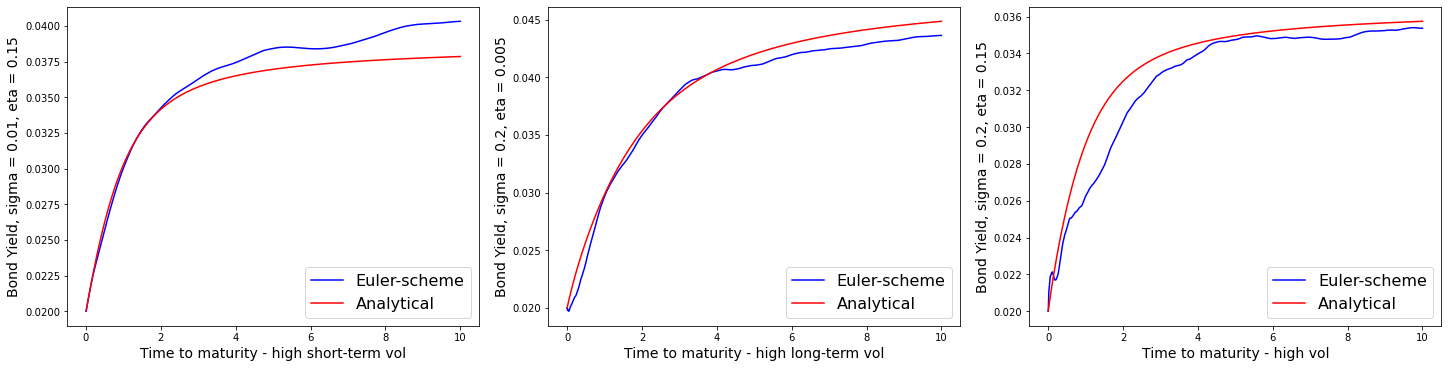

In [17]:
fig2, f2_axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True,figsize=(20,5))
f2_axes[0].plot(t,bond_sim(alpha,beta,sigma,phi,0.15,t,nsims),'-b',label = "Euler-scheme")
f2_axes[0].plot(t,bond_analytical(alpha,beta,sigma,phi,0.15,t),'-r',label = "Analytical")
#f2_axes[0].plot(t,B(2,t),color='k',label = "Function B (alpha = 2)")
f2_axes[0].legend(loc=4,prop={'size': 16})
#f2_axes[0].title('Compare Euler-scheme and Analytical - high bond yield')
f2_axes[0].set_ylabel("Bond Yield, sigma = 0.01, eta = 0.15", fontsize=14)
f2_axes[0].set_xlabel('Time to maturity - high short-term vol', fontsize=14)

f2_axes[1].plot(t,bond_sim(alpha,beta,0.2,phi,eta,t,nsims),'-b',label = "Euler-scheme")
f2_axes[1].plot(t,bond_analytical(alpha,beta,0.2,phi,eta,t),'-r',label = "Analytical")
#f2_axes[1].plot(x,gamma(K, tau, x, r, 1.5*sigma),color='k',label='Volatility = 30%')
f2_axes[1].legend(loc=4,prop={'size': 16})
#f2_axes[1].title('Compare Euler-scheme and Analytical - low bond yield')
f2_axes[1].set_ylabel('Bond Yield, sigma = 0.2, eta = 0.005', fontsize=14)
f2_axes[1].set_xlabel('Time to maturity - high long-term vol', fontsize=14)

f2_axes[2].plot(t,bond_sim(alpha,beta,0.2,phi,0.15,t,nsims),'-b',label = "Euler-scheme")
f2_axes[2].plot(t,bond_analytical(alpha,beta,0.2,phi,0.15,t),'-r',label = "Analytical")
#f2_axes[1].plot(x,gamma(K, tau, x, r, 1.5*sigma),color='k',label='Volatility = 30%')
f2_axes[2].legend(loc=4,prop={'size': 16})
#f2_axes[1].title('Compare Euler-scheme and Analytical - low bond yield')
f2_axes[2].set_ylabel('Bond Yield, sigma = 0.2, eta = 0.15', fontsize=14)
f2_axes[2].set_xlabel('Time to maturity - high vol', fontsize=14)

In [18]:
theta=simtheta(t,beta,phi,eta,nsims)

In [19]:
rt=simr(t,alpha,theta,sigma,nsims)

In [20]:
bondyield,bondprice = BondYp(t,rt,1000)

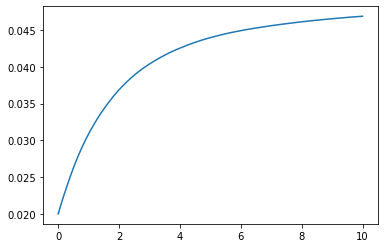

In [21]:
plt.plot(t,bondyield)

# Analytical bond yield curve

In [22]:
def bond_analytical (alpha,beta,sigma,phi,eta,t):
    B_t=B(alpha,t)
    C_t=C(alpha,beta,t,B_t)
    A_t=A(alpha,beta,sigma,phi,eta,t,B_t,C_t)
    return (-A_t+B_t*r0+C_t*theta0)/t

In [23]:
B_t=B(alpha,t)
C_t=C(alpha,beta,t,B_t)
A_t=A(alpha,beta,sigma,phi,eta,t,B_t,C_t)

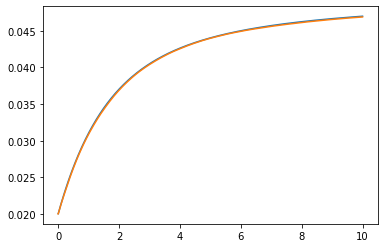

In [24]:
plt.plot(t,(-A_t+B_t*r0+C_t*theta0)/t)
plt.plot(t,bondyield)